# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning
## Contexte
Afin d'aider une association de protection des animaux, il est demandé de classer les images de la base de données de l'association dans le but de déterminer la race des chiens sur les images

## Démarches
Pour réaliser la demande de l'association nous procédons en plusieurs étapes :
- téléchargement des images
- test des différentes corrections appliquables
- création d'un réseau de neurones simple
- test de transfer learning à partir de différents modèles  
Le modèle le plus performant sera ensuite déployé dans un code afin de faciliter son utilisation.

## Notebook développement d'un modèle DeepLearning

## Modules Python

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras, data
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import vgg16 
import matplotlib.pyplot as plt
import shutil

### Vérification de l'utilisation du GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Variables

In [3]:
n_class = 20 # nombre de races de chiens conservées pour le développement
NB = "Colab"
#NB = "jupyter"

## Import des images
Les répertoires des races de chiens conservées sont placés soit dans la mémoire du projet Colab, soit dans un répertoire temporaire.

In [4]:
if NB == "Colab" :
    IDIR = "/content/drive/Othercomputers/Mon ordinateur portable/P6_classer_image/data/Images"
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/data/"
else :
    IDIR = "data/Images"
    DIR = "./tmp/"
if not os.path.isdir(DIR+"/Images"):
    os.makedirs(DIR+"/Images")
list_class = os.listdir(IDIR)[:n_class]
print("Races de chiens :")
print(list_class)
for class_name in list_class :
    shutil.copytree(IDIR+"/"+class_name, DIR+"/Images/"+class_name, symlinks=False, ignore=None)

Mounted at /content/drive
Races de chiens :
['n02107683-Bernese_mountain_dog', 'n02107908-Appenzeller', 'n02108422-bull_mastiff', 'n02109525-Saint_Bernard', 'n02110185-Siberian_husky', 'n02110958-pug', 'n02112018-Pomeranian', 'n02112137-chow', 'n02112350-keeshond', 'n02112706-Brabancon_griffon', 'n02113023-Pembroke', 'n02113186-Cardigan', 'n02113624-toy_poodle', 'n02113712-miniature_poodle', 'n02113799-standard_poodle', 'n02113978-Mexican_hairless', 'n02115641-dingo', 'n02109047-Great_Dane', 'n02111889-Samoyed', 'n02115913-dhole']


## fonctions utiles

In [5]:
def plot_history(history, epochs) :
    """
    function to plot the history of the tensorflow fit
    parameters : history 
                 epochs : int : n epochs in the history
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)

    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [6]:
def load_data(DIR, height=200, width=200, batch_size=128):
    """
    Function to load datasets and split in train/val set
    Base on tensorflow image_dataset_from_directory function
    parameters : DIR : directory of Images
                 height : int : height of images
                 width : int : width of images
                 batch_size : int
    return train dataset, validation dataset
    """
    train_ds = keras.utils.image_dataset_from_directory(DIR,\
                                                        labels='inferred' ,# labels générés depuis les sous dossier
                                                        label_mode = 'categorical', #créer un vecteur de taille n_class
                                                        color_mode = "rgb", #image de dimension L*H*3
                                                        image_size = (height, width), # rescaling des images
                                                        validation_split=0.2, # %validation
                                                        batch_size=batch_size,
                                                        subset = 'training', #retourne le training set
                                                        seed=43
                                                        )
    test_ds = keras.utils.image_dataset_from_directory(DIR,\
                                                       labels='inferred' ,# labels générés depuis les sous dossier
                                                       label_mode = 'categorical', #créer un vecteur de taille n_class
                                                   color_mode = "rgb", #image de dimension L*H*3
                                                   image_size = (height, width), # rescaling des images
                                                   validation_split=0.2, # %validation
                                                   subset = 'validation', #retourne le training set
                                                   batch_size=batch_size,
                                                   seed=43
                                            )
    return train_ds, test_ds
    

In [7]:
def split_test_val(ds, prct=0.2) :
    """
    function to split a tensorflow dataset into 2
    """
    n = int(np.ceil(1/prct))
    print(n)
    val_batches = tf.data.experimental.cardinality(ds)
    test_ds = ds.take(val_batches // n)
    val_ds = ds.skip(val_batches // n)
    return val_ds, test_ds

## Préprocessing des données


### Chargement des données
Les données sont chargées grâce à la fonction implémentée dans Tensorflow.  
La séparation du jeu d'apprentissage et de test est réalisée également par cette fonction.  
Cela permet de gagner en mémoire car l'ensemble des données n'est pas stocké en permanence en mémoire vive.

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", batch_size=32)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5


In [ ]:
print(f'Number of training batches: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation batches: {tf.data.experimental.cardinality(val_ds)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_ds)}')

Number of training batches: 87
Number of validation batches: 18
Number of test batches: 4


### Correction du nom des labels
Les noms des races de chiens sont précédés d'un numéro : on le supprime

In [ ]:
train_ds.class_names = list(map(lambda x : "-".join(x.split("-")[1:]), train_ds.class_names))
#val_ds.class_names = list(map(lambda x : "-".join(x.split("-")[1:]), val_ds.class_names))
#test_ds.class_names = list(map(lambda x : "-".join(x.split("-")[1:]), test_ds.class_names))

In [ ]:
print(f"Nombre de classes : {len(train_ds.class_names)}")
print("Listes des classes :")
print(train_ds.class_names)

Nombre de classes : 20
Listes des classes :
['Bernese_mountain_dog', 'Appenzeller', 'bull_mastiff', 'Great_Dane', 'Saint_Bernard', 'Siberian_husky', 'pug', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole']


### Normalisation des données
Les intensités de chaque couleur est codée sur 255 niveaux. Un réseau de neurones fonctionne mieux avec des valeurs entre 0 et 1.  
Pour cela on divise chaque intensité par 255.  
Il est également possible d'ajouter en première couche du réseau une couche de normalisation

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normtrain_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normval_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
normtest_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### passage des données en RAM
Le passage des données en RAM permet d'accélérer le code.

In [ ]:
AUTOTUNE = data.experimental.AUTOTUNE
normtrain_ds = normtrain_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
normtest_ds = normtest_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Réseau de neurones sans transfert learning

### réseau simple
On commence par créer un réseau simple, composé de :  
- une couche de convolution de 32 filtres de tailles (3*3)
- une couche Flatten pour repasser en 1D
- une couche Dense de 128 neurones
- une couche de prédictions de 20 neurones avec une fonction d'activation softmax  

Le modèle est optimisé avec un ADAM par descente de gradient.  
La fonction de perte est "categorical_crossentropy" compte tenu de format de la sortie.  
On calcul également la précision du modèle.

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    layers.Conv2D(32, (3, 3), input_shape=(200,200, 3), padding='same', activation='relu'),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 flatten_1 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_2 (Dense)             (None, 128)               163840128 
                                                                 
 dense_3 (Dense)             (None, 20)                2580      
                                                                 
Total params: 163,843,604
Trainable params: 163,843,604
Non-trainable params: 0
_________________________________________________________________


Le modèle est composé de 3 couches paramètrables, prenant en entrée des images 200*200. 
Il contient 163M de paramètres...

In [ ]:
history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Epoch 1/10
87/87 [==============================] - 8s 81ms/step - loss: 14.5098 - accuracy: 0.0601 - val_loss: 2.9798 - val_accuracy: 0.0838
Epoch 2/10
87/87 [==============================] - 7s 78ms/step - loss: 2.8247 - accuracy: 0.1685 - val_loss: 2.9023 - val_accuracy: 0.1408
Epoch 3/10
87/87 [==============================] - 7s 79ms/step - loss: 1.8335 - accuracy: 0.5293 - val_loss: 3.0793 - val_accuracy: 0.1355
Epoch 4/10
87/87 [==============================] - 7s 79ms/step - loss: 0.5198 - accuracy: 0.9036 - val_loss: 3.3762 - val_accuracy: 0.1301
Epoch 5/10
87/87 [==============================] - 8s 89ms/step - loss: 0.1121 - accuracy: 0.9877 - val_loss: 3.8855 - val_accuracy: 0.1123
Epoch 6/10
87/87 [==============================] - 7s 79ms/step - loss: 0.0398 - accuracy: 0.9982 - val_loss: 3.9113 - val_accuracy: 0.1355
Epoch 7/10
87/87 [==============================] - 7s 79ms/step - loss: 0.0343 - accuracy: 0.9986 - val_loss: 3.8238 - val_accuracy: 0.1319
Epoch 8/10
8

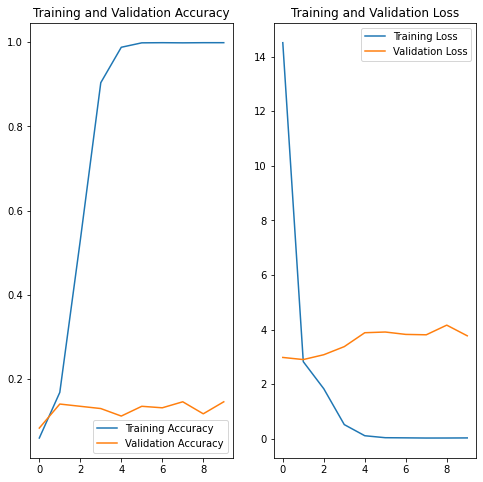

In [ ]:
plot_history(history,10)

On remarque une très bonne précision sur le jeu d'apprentissage alors que la précision sur le jeu de validation reste très faible. Cela est caractéristique d'un sur-apprentissage

### lutter contre le surapprentissage

#### Augmentation de données
Cette technique est utile lorsque l'on a une petite base de données qui peut facilement provoquer un sur apprentissage : le modèle est assez complexe pour s'adapter facilement aux images d'apprentissage (en apprenant du bruit par exemple) au détriment de la précision sur le jeu de validation.  
Pour lutter contre ce phénomène il est possible d'appliquer des opérations géométriques (rotation, zoom, ...) pour augmenter artificiellement le nombre d'images.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(200,
                                  200,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Représentation des transformations

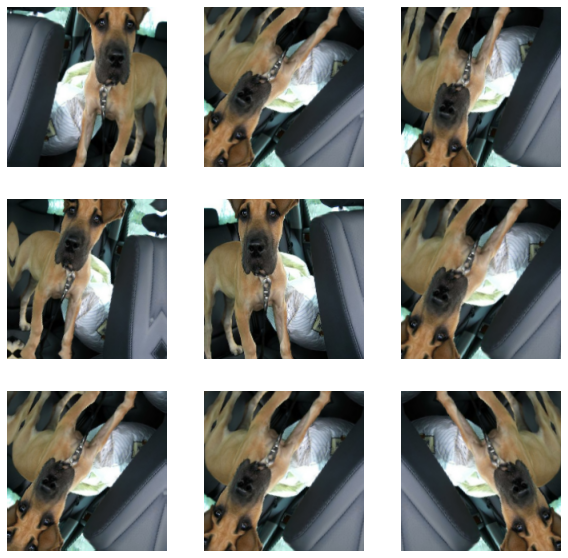

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### réseau de neurones avec une couche d'augmentation de données

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 flatten_2 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               163840128 
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
Total params: 163,843,604
Trainable params: 163,843,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
87/87 [======================

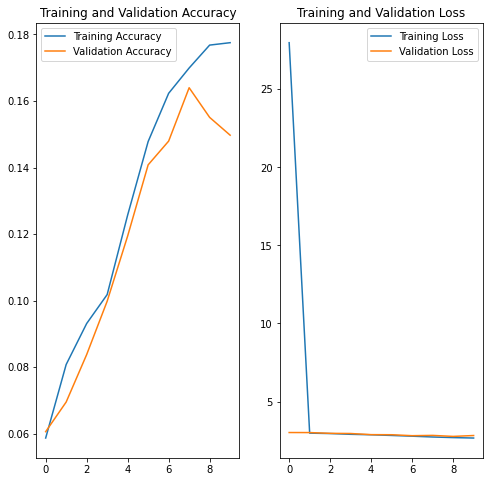

In [ ]:
plot_history(history,10)

L'augmentation de données permet de limiter (voir annuler le sur apprentissage). On remarque que la précision est donc d'environ 0.2

#### Dropout
Cette technique consiste à éteindre une partie des neurones d'une couche du réseau, en définissant l'activation à 0, de manière aléatoire.  
Cela limite le surapprentissage.

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    layers.Conv2D(32, (3, 3), input_shape=(200,200, 3), padding='same', activation='relu'),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 dropout (Dropout)           (None, 200, 200, 32)      0         
                                                                 
 flatten_3 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_6 (Dense)             (None, 128)               163840128 
                                                                 
 dense_7 (Dense)             (None, 20)                2580      
                                                                 
Total params: 163,843,604
Trainable params: 163,843,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
87/87 [======================

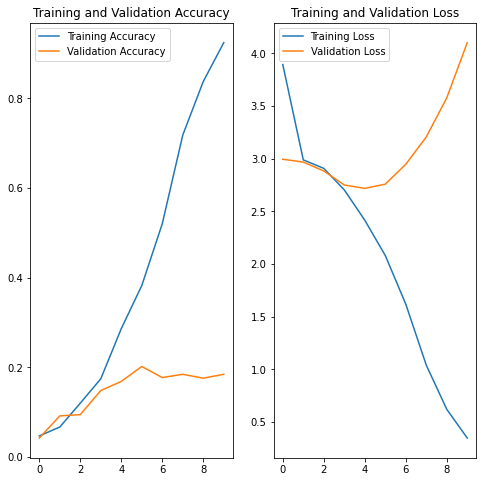

In [ ]:
plot_history(history,10)

Le Dropout est moins efficace pour lutter contre le sur-apprentissage que l'augmentation des données.

### effet du nombre de couche de convolution

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 flatten_4 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_8 (Dense)             (None, 128)               163840128 
                                                                 
 dense_9 (Dense)             (None, 20)                2580      
                                                                 
Total params: 163,852,852
Trainable params: 163,852,85

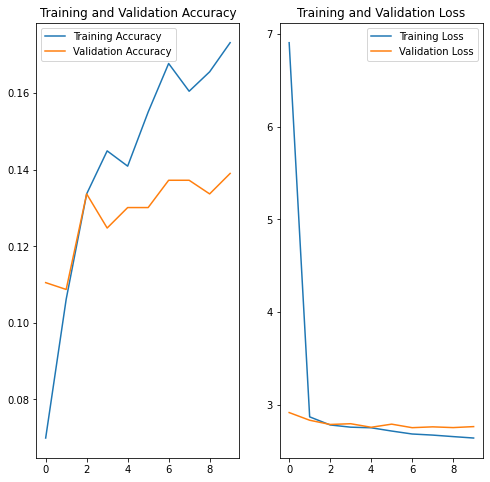

In [ ]:
plot_history(history,10)

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normtest_ds,
                    epochs=10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 flatten_5 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_10 (Dense)            (None, 128)               163840128 
                                                                 
 dense_11 (Dense)            (None, 20)               

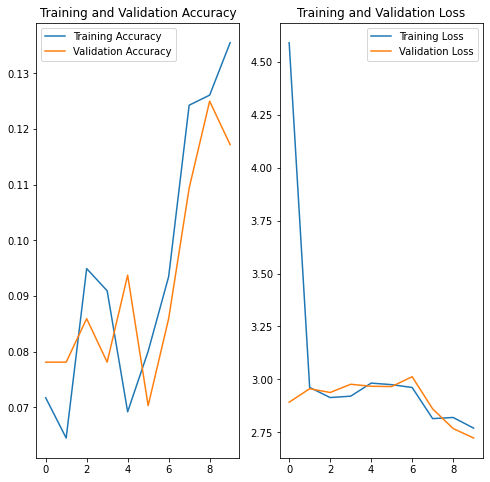

In [ ]:
plot_history(history,10)

L'effet du nombre de couche de convolution n'est pas évident.   
On complexifie fortement le modèle, ce qui peut le rendre plus long à apprendre, d'où une précision plus faible après 10 epochs

### Effet des couches de Pooling

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 320000)            0         
                                                     

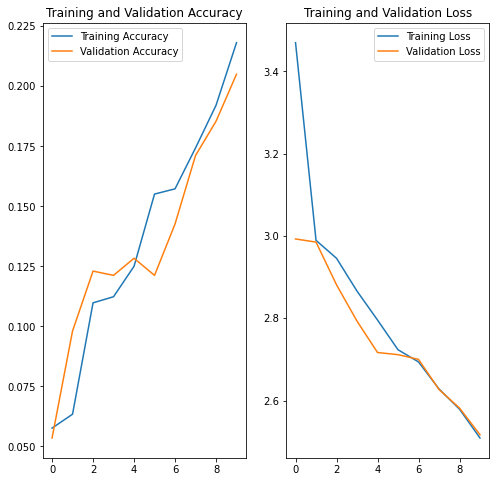

In [ ]:
plot_history(history,10)

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 32)      

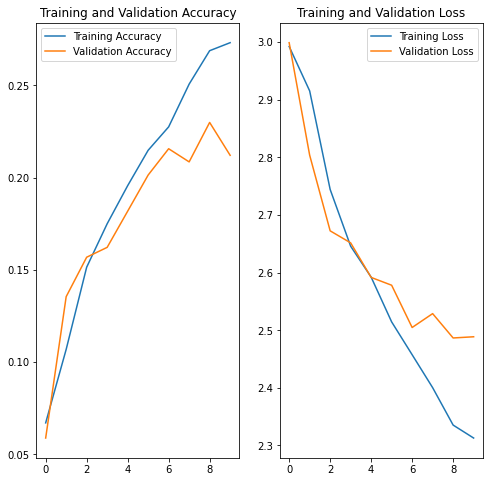

In [ ]:
plot_history(history,10)

Augmenter le nombre de couche de Pooling permet d'accélerer l'apprentissage. Cela est compréhensible par le fait que l'on compresse l'information et que l'on a moins de paramètres à entrainer.  
Cependant il faut prendre garde à ne pas supprimer trop d'informations en multipliant le nombre de couche de Pooling.

### Effet du nombre de couche fully connected

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 50, 32)      

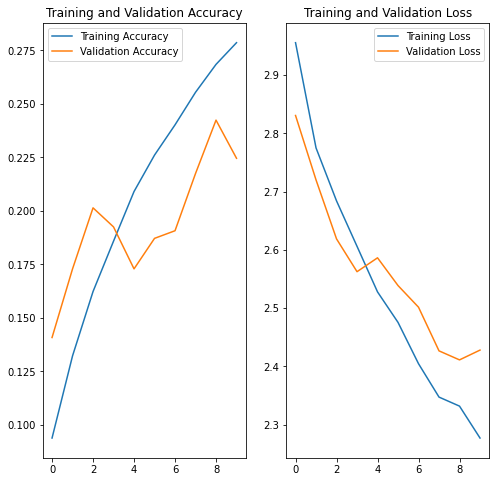

In [ ]:
plot_history(history,10)

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=10)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 50, 50, 32)      

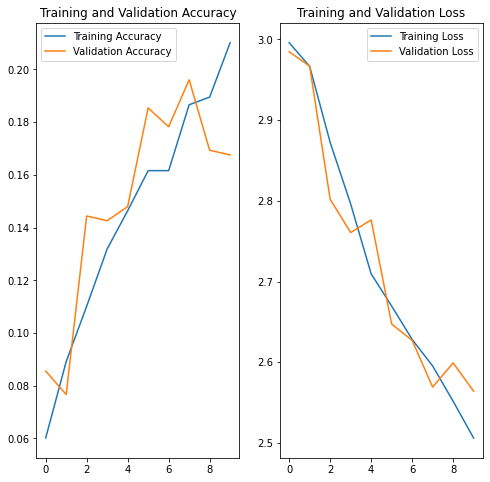

In [ ]:
plot_history(history,10)

Augmenter le nombre de couche fully-connected permet d'améliorer la précision au détriment du nombre d'epochs nécessaire pour l'apprentissage

### Reseau de neurones complexes

In [ ]:
num_classes = len(train_ds.class_names)

model = Sequential([
                    data_augmentation,
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(normtrain_ds,
                    validation_data=normval_ds,
                    epochs=20)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 50, 32)      

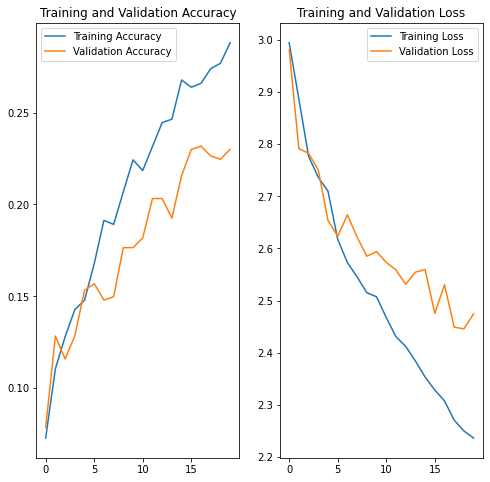

In [ ]:
plot_history(history,20)

### Optimisation des hyperparamètres
Utilisation d'un réseau de neurones avec :
- une couche de normalisation
- une couche d'augmentation des données
- Au moins 3 couches de convolution
- couche de pooling
- au moins 2 couche fully-connected


#### taille des images en inputs


Image size = (200,200)
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 100, 100, 32)      9248      
            

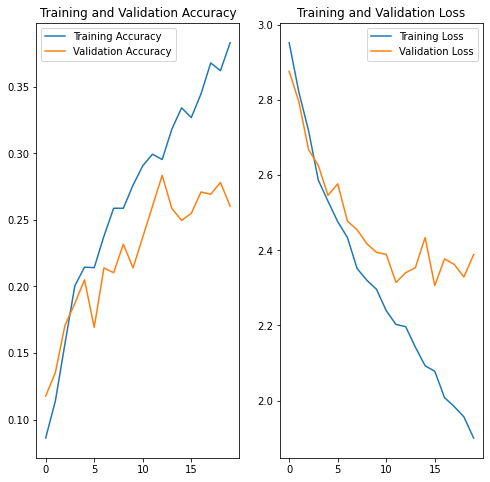


Image size = (300,300)
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 150, 150, 32)      9248      
            

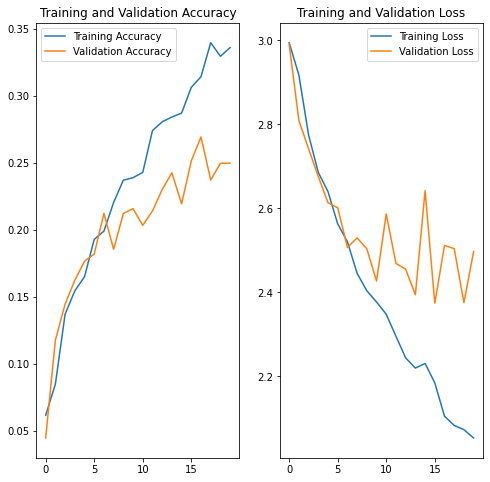


Image size = (400,400)
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 400, 400, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 400, 400, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 200, 200, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 200, 200, 32)      9248      
            

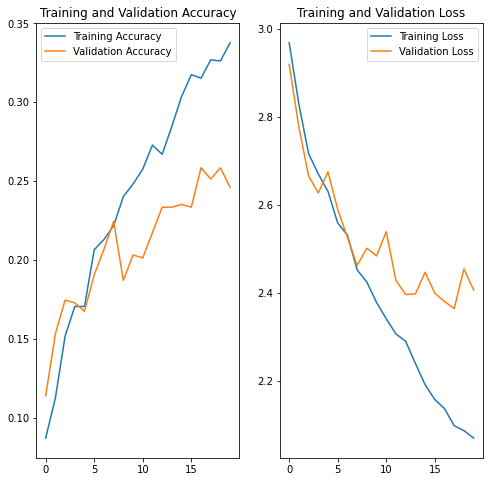

In [ ]:
for h, w in [(200,200), (300,300), (400,400)] :
    print()
    print("="*50)
    print(f"Image size = ({h},{w})")
    print(f"="*50)
    train_ds, val_ds = load_data(DIR+"/Images", batch_size=32, height=h, width=w)
    val_ds, test_ds = split_test_val(val_ds, prct=0.2)
    num_classes = len(train_ds.class_names)
    data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(h, w, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
    model = Sequential([
                        data_augmentation,
                        layers.Rescaling(1./255),
                        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=20)

    plot_history(history,20)

La taille des images influence légérement la précision et la vitesse d'apprentissage :    
- plus l'image est petite, plus l'apprentissage est rapide
- plus l'image est grande, plus il est possible de détecter des détails

#### Nombre de filtres par couche de convolution


Nombre de filtres par couche de convolution = 16
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 100, 100, 16)   

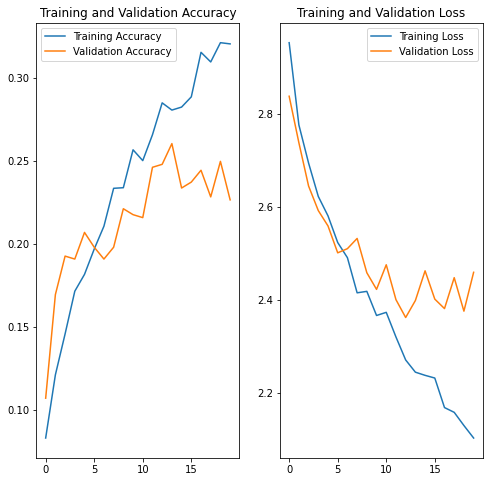


Nombre de filtres par couche de convolution = 32
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 100, 100, 32)   

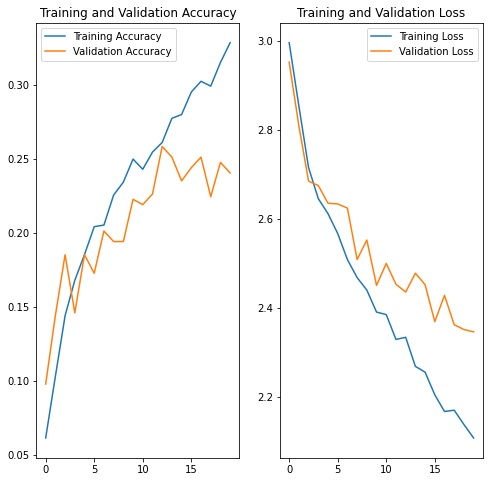


Nombre de filtres par couche de convolution = 64
Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_31 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 100, 100, 64)   

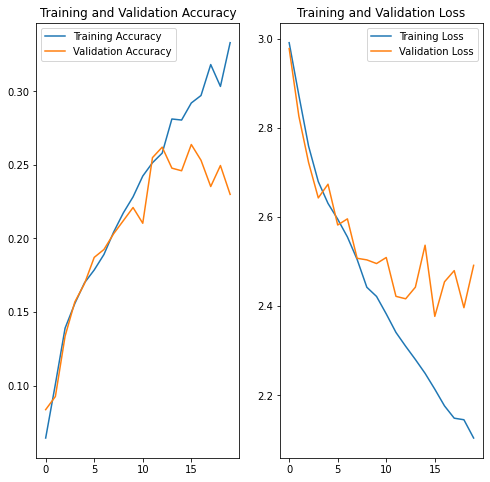

In [ ]:
for n in [16, 32, 64] :
    print()
    print("="*50)
    print(f"Nombre de filtres par couche de convolution = {n}")
    print(f"="*50)
    
    train_ds, val_ds = load_data(DIR+"/Images", batch_size=32, height=200, width=200)
    val_ds, test_ds = split_test_val(val_ds, prct=0.2)
    num_classes = len(train_ds.class_names)
    data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(200, 200, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
    model = Sequential([
                        data_augmentation,
                        layers.Rescaling(1./255),
                        layers.Conv2D(n, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(n, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(n, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=20)

    plot_history(history,20)

Le nombre de filtres par couche de convolution influe sur la précision du modèle. Plus il y a de filtres, meilleure est la précision. 

#### taille des filtres de convolution

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5

Filter size = (2,2)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_37 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 200, 200, 32)      416       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 100, 100, 32)      4128      
               

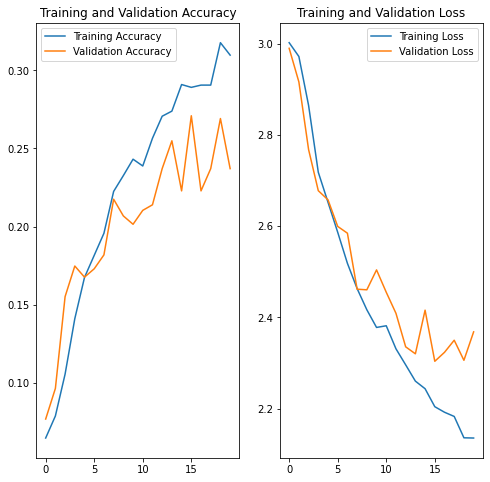


Filter size = (3,3)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_39 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                           

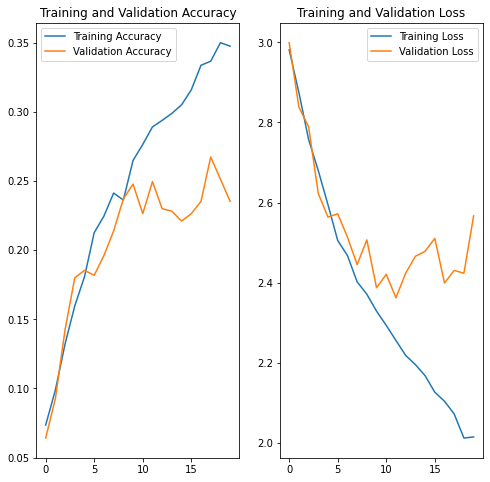


Filter size = (4,4)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_41 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 200, 200, 32)      1568      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 100, 100, 32)      16416     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                           

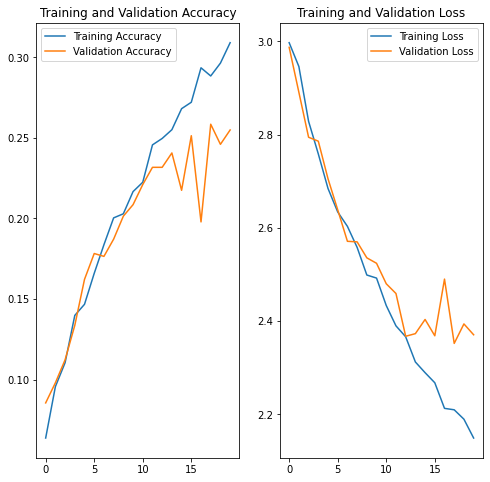

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", batch_size=32, height=200, width=200)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)
for h, w in [(2,2), (3,3), (4,4)] :
    print()
    print("="*50)
    print(f"Filter size = ({h},{w})")
    print(f"="*50)
    num_classes = len(train_ds.class_names)
    data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(200, 200, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
    model = Sequential([
                        data_augmentation,
                        layers.Rescaling(1./255),
                        layers.Conv2D(32, (h, w), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (h,w),  padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (h,w), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=20)

    plot_history(history,20)

#### Taille des couches fully-connected

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5

Fully-connected size = 64)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_45 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 100, 100, 32)      9248      
        

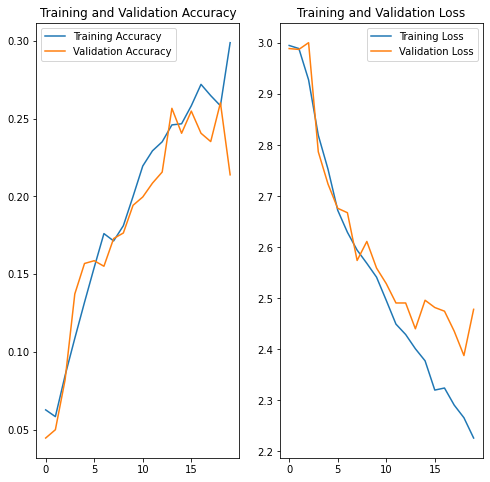


Fully-connected size = 128)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_47 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                   

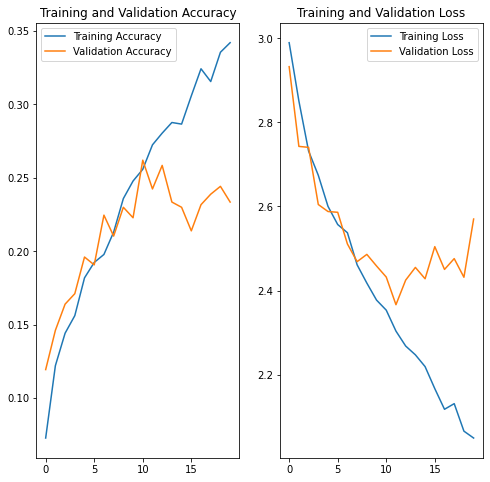


Fully-connected size = 256)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_49 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_83 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                   

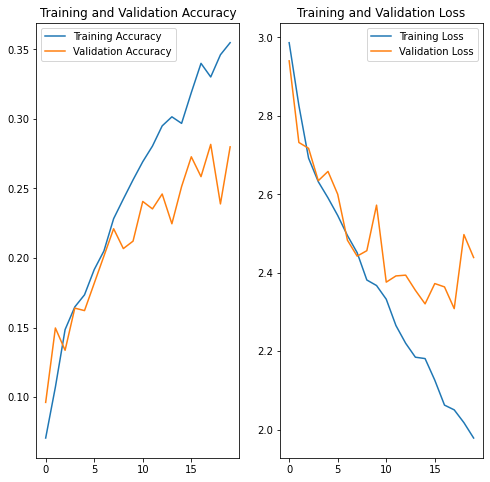


Fully-connected size = 512)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_51 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_18 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                   

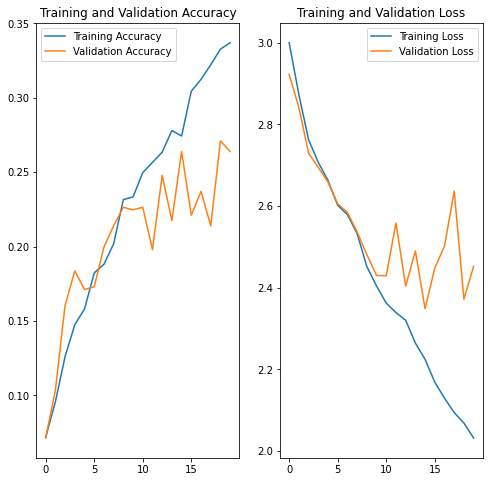


Fully-connected size = 1024)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_53 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_19 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_89 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                  

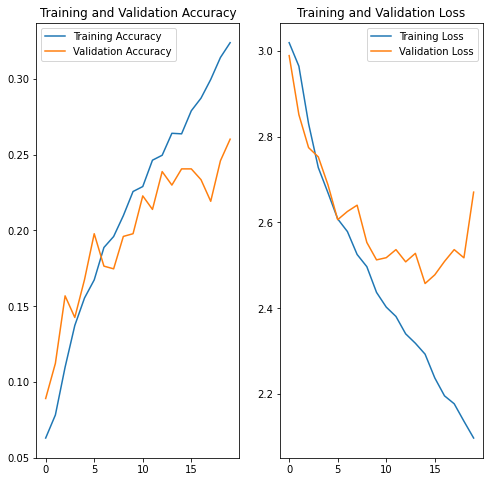

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", batch_size=32, height=200, width=200)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)
for n in [64, 128, 256, 512, 1024] :
    print()
    print("="*50)
    print(f"Fully-connected size = {n})")
    print(f"="*50)
    num_classes = len(train_ds.class_names)
    data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(200, 200, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
    model = Sequential([
                        data_augmentation,
                        layers.Rescaling(1./255),
                        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3,3),  padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Flatten(),
                        layers.Dense(n, activation='relu'),
                        layers.Dense(n, activation='relu'),
                        layers.Dense(n, activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=20)

    plot_history(history,20)

L'augmentation du nombres de neurones dans les couches fully-connected permet de complexifier le modèle à la suite de l'extraction de features. Cela peut légérement améliorer la précision.

#### Nombre d'epochs

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5

n epochs = 5)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_55 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_20 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_92 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 100, 100, 32)      9248      
                     

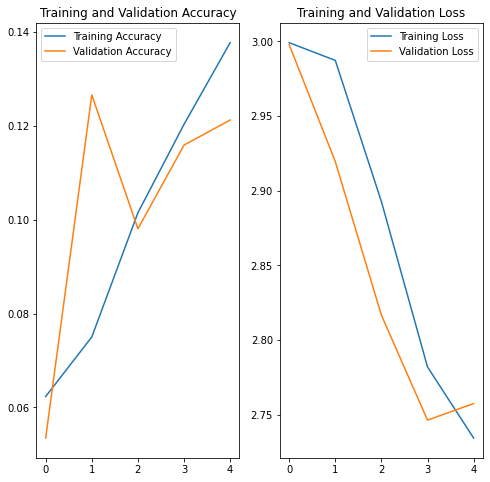


n epochs = 10)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_57 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_21 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                

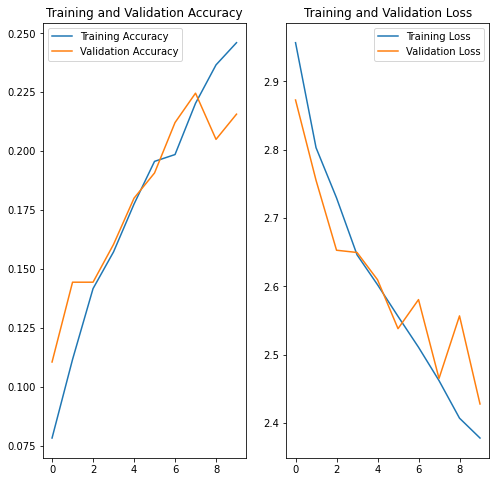


n epochs = 20)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_59 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_22 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                

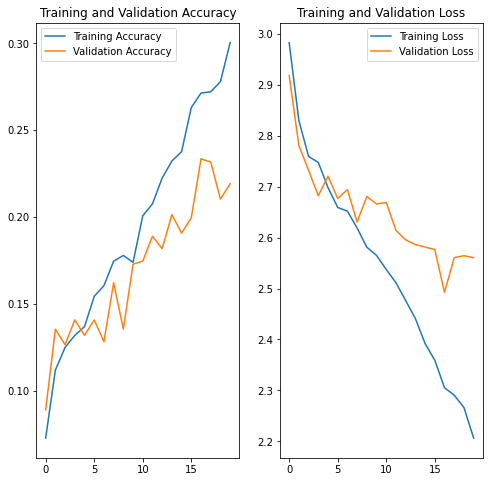


n epochs = 50)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_61 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_101 (Conv2D)         (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                

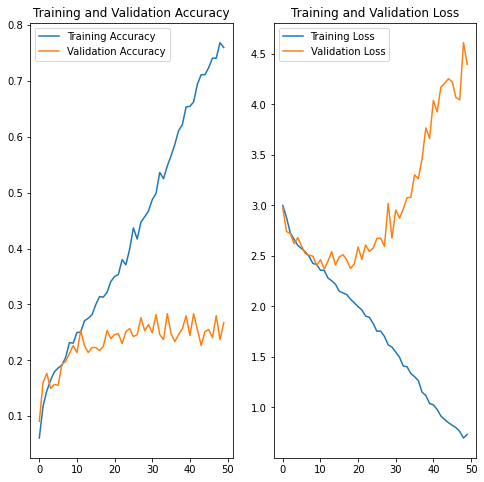

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", batch_size=32, height=200, width=200)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)
for n in [5,10,20,50] :
    print()
    print("="*50)
    print(f"n epochs = {n})")
    print(f"="*50)
    num_classes = len(train_ds.class_names)
    data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(200, 200, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
    model = Sequential([
                        data_augmentation,
                        layers.Rescaling(1./255),
                        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3,3),  padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                        layers.MaxPooling2D(2,2),
                        layers.Flatten(),
                        layers.Dense(512, activation='relu'),
                        layers.Dense(512, activation='relu'),
                        layers.Dense(512, activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=n)

    plot_history(history,n)

Le nombre d'epoh est à définir de manière à obtenir la meilleur précision sur le jeu de validation. Il faut donc s'arréter avant d'entrer en sur-apprentissage. Il existe dans tensorflow une méthode permettant de sauvegarder le meilleur modèle durant l'apprentissage.

## Transfer Learning VGG16

### Visualisation du modèle

In [ ]:
vgg = vgg16.VGG16()
vgg.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Le modèle VGG16 est composé de 5 blocks composés de  :
- 2 couches de convolution
- 1 couche de MaxPooling

A la suite de ces blocks on ajoute une couche Flatten pour convertir les données en vecteurs, puis deux couches fully connected de taille 4096. Le modèle termine évidemment pour une couche de prédiction.  
Le modèle total à 138M de paramètres.

### creation dataset

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", height=224, width=224, batch_size=32)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### base modele

In [ ]:
base_model = vgg16.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

On  récupère ici que la partie basse du modèle.

### Création modèle
Notre modèle sera composé :
- 1 couche d'augmentation de données pour lutter contre le sur-apprentissage
- 1 couche de préprocessing contenue dans la librairie VGG16
- le modèle de base
- Une couche de transformation de matrices en vecteurs
- 1 couche Dropout 
- La couche de prédiction

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), 
                                      layers.RandomRotation(0.1), 
                                      layers.RandomZoom(0.1)])

In [ ]:
preprocess_vgg16 = vgg16.preprocess_input

In [ ]:
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")

In [ ]:
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_average_layer = tf.keras.layers.Flatten()

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_vgg16(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

### Apprentissage de la dernière couche
L'apprentissage de la couche de prédiction uniquement permet de conserver les poids du modèle initiale et d'entrainer uniquement la nouvelle couche, soit 502k paramètres

In [ ]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 36s 236ms/step - loss: 18.3121 - accuracy: 0.2525 - val_loss: 8.0841 - val_accuracy: 0.5668
Epoch 2/30
87/87 [==============================] - 19s 209ms/step - loss: 7.2723 - accuracy: 0.5507 - val_loss: 6.3944 - val_accuracy: 0.6684
Epoch 3/30
87/87 [==============================] - 20s 230ms/step - loss: 5.1593 - accuracy: 0.6478 - val_loss: 4.8902 - val_accuracy: 0.7558
Epoch 4/30
87/87 [==============================] - 19s 215ms/step - loss: 4.1481 - accuracy: 0.7134 - val_loss: 4.7060 - val_accuracy: 0.7469
Epoch 5/30
87/87 [==============================] - 19s 213ms/step - loss: 2.8705 - accuracy: 0.7678 - val_loss: 4.7383 - val_accuracy: 0.7469
Epoch 6/30
87/87 [==============================] - 19s 211ms/step - loss: 2.6070 - accuracy: 0.7982 - val_loss: 4.6758 - val_accuracy: 0.7665
Epoch 7/30
87/87 [==============================] - 19s 213ms/step - loss: 2.1277 - accuracy: 0.8246 - val_loss: 4.3518 - val_accuracy: 0.789

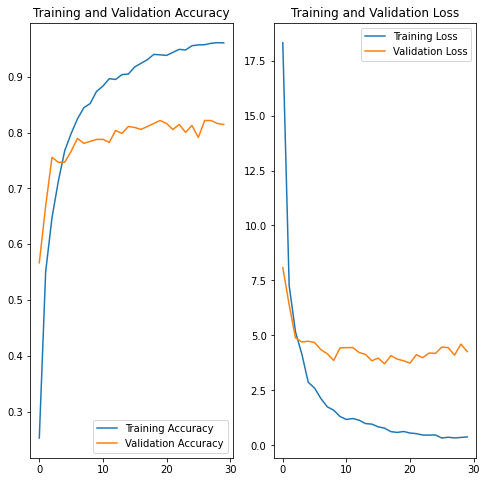

In [ ]:
plot_history(history, 30)

L'apprentissage de la couche de prédictions uniquement permet d'obtenir une précision d'environ 81% sur le jeu de validation.  
Cependant on observe rapidement un sur-apprentissage

### Ajout des couches fully-connected
On ajoute dans le modèle de base les couches fully-connected de taille 4096. Cela diminue le nombre de paramètre entrainable pour la couche de prédiction.

In [ ]:
base_model = vgg16.VGG16(input_shape=(224,224,3), include_top=True, weights='imagenet')

In [ ]:
last_layer = base_model.layers[-2]
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

n_model = tf.keras.models.Model(base_model.inputs, last_layer.output)
n_model.summary()

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_vgg16(x)
x = n_model(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, prediction_layer.output)

for layer in base_model.layers :
    layer.trainable = False
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 20s 214ms/step - loss: 1.8841 - accuracy: 0.4464 - val_loss: 0.8041 - val_accuracy: 0.7148
Epoch 2/30
87/87 [==============================] - 20s 223ms/step - loss: 0.7308 - accuracy: 0.7670 - val_loss: 0.5356 - val_accuracy: 0.8039
Epoch 3/30
87/87 [==============================] - 19s 220ms/step - loss: 0.5545 - accuracy: 0.8120 - val_loss: 0.4048 - val_accuracy: 0.8556
Epoch 4/30
87/87 [==============================] - 19s 213ms/step - loss: 0.4792 - accuracy: 0.8399 - val_loss: 0.3958 - val_accuracy: 0.8663
Epoch 5/30
87/87 [==============================] - 19s 212ms/step - loss: 0.4360 - accuracy: 0.8489 - val_loss: 0.3726 - val_accuracy: 0.8699
Epoch 6/30
87/87 [==============================] - 19s 215ms/step - loss: 0.3842 - accuracy: 0.8725 - val_loss: 0.3548 - val_accuracy: 0.8734
Epoch 7/30
87/87 [==============================] - 19s 216ms/step - loss: 0.3513 - accuracy: 0.8801 - val_loss: 0.3390 - val_accuracy: 0.8859

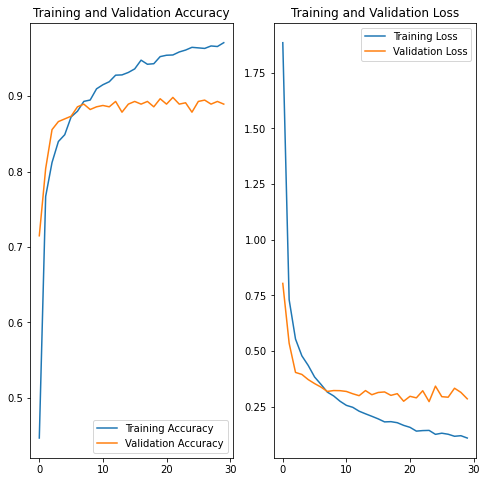

In [ ]:
plot_history(history, 30)

L'ajout des couches fully-connected permet d'améliorer la précision sur le jeu de validation d'environ 10%.

### Apprentissage de toutes les couches fully-connected

In [ ]:
for layer in base_model.layers[:-2] :
    layer.trainable = False
for layer in base_model.layers[-2:]:
    layer.trainable = True
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_3 (Functional)        (None, 4096)              134260544 
                                                                 
 dense_2 (Dense)             (None, 20)                8194

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 20s 219ms/step - loss: 0.6361 - accuracy: 0.8478 - val_loss: 0.8133 - val_accuracy: 0.8396
Epoch 2/30
87/87 [==============================] - 20s 229ms/step - loss: 0.2688 - accuracy: 0.9232 - val_loss: 0.8889 - val_accuracy: 0.8645
Epoch 3/30
87/87 [==============================] - 19s 220ms/step - loss: 0.2020 - accuracy: 0.9413 - val_loss: 0.7717 - val_accuracy: 0.8627
Epoch 4/30
87/87 [==============================] - 19s 215ms/step - loss: 0.1344 - accuracy: 0.9587 - val_loss: 0.7737 - val_accuracy: 0.8627
Epoch 5/30
87/87 [==============================] - 19s 217ms/step - loss: 0.1077 - accuracy: 0.9703 - val_loss: 0.7278 - val_accuracy: 0.8645
Epoch 6/30
87/87 [==============================] - 20s 221ms/step - loss: 0.1064 - accuracy: 0.9717 - val_loss: 0.7260 - val_accuracy: 0.8717
Epoch 7/30
87/87 [==============================] - 19s 219ms/step - loss: 0.1135 - accuracy: 0.9674 - val_loss: 0.8211 - val_accuracy: 0.8663

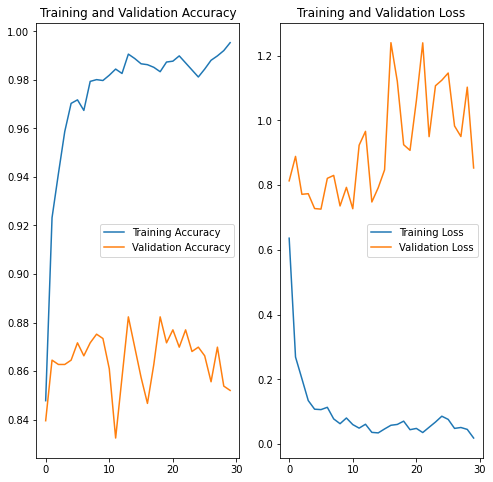

In [ ]:
plot_history(history, 30)

L'apprentissage de toutes les couches fully connected ne permet pas d'améliorer la précision sur le jeu de validation mais augmente le sur-apprentissage.

### entrainement de toutes les couches

In [ ]:
for layer in base_model.layers :
    layer.trainable = True
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_3 (Functional)        (None, 4096)              134260544 
                                                                 
 dense_2 (Dense)             (None, 20)                8194

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/30
87/87 [==============================] - 55s 557ms/step - loss: 0.0819 - accuracy: 0.9801 - val_loss: 0.7872 - val_accuracy: 0.8538
Epoch 2/30
87/87 [==============================] - 47s 535ms/step - loss: 0.0546 - accuracy: 0.9859 - val_loss: 0.8034 - val_accuracy: 0.8556
Epoch 3/30
87/87 [==============================] - 47s 535ms/step - loss: 0.0346 - accuracy: 0.9909 - val_loss: 0.8863 - val_accuracy: 0.8467
Epoch 4/30
87/87 [==============================] - 48s 547ms/step - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.8414 - val_accuracy: 0.8414
Epoch 5/30
87/87 [==============================] - 46s 527ms/step - loss: 0.0646 - accuracy: 0.9815 - val_loss: 0.7873 - val_accuracy: 0.8378
Epoch 6/30
87/87 [==============================] - 47s 538ms/step - loss: 0.0471 - accuracy: 0.9866 - val_loss: 0.7519 - val_accuracy: 0.8396
Epoch 7/30
87/87 [==============================] - 48s 546ms/step - loss: 0.0372 - accuracy: 0.9888 - val_loss: 0.8898 - val_accuracy: 0.8414

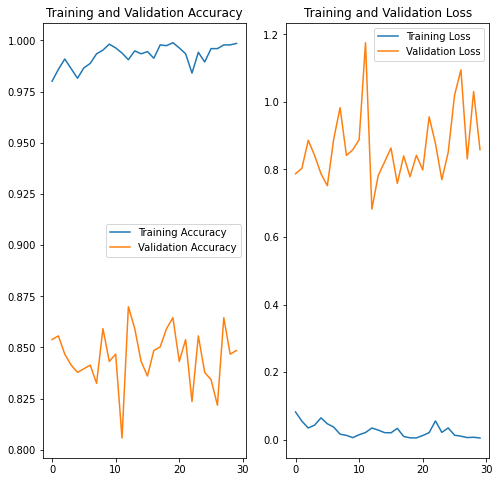

In [ ]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds)
plot_history(history, 30)

L'apprentissage de toutes les couches du réseau ne permet pas non plus d'améliorer la précision sur le jeu de validation.

## transfer learning mobilnet_v2

### creation dataset

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", height=160, width=160, batch_size=32)

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 18
Number of test batches: 4


### configuration performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

### preprocessing

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### base du modèle

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_8[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Le modele MobileNet_V2 est beaucoup plus complexe que le modèle VGG16. Il est composé de 16 blocks de convolution.  
Le modèle créé pour la prédiction suit la même logique que pour le modèle VGG16.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### apprentissage de la couche de prédiction
La couche de prédiction contient 25k paramètres.

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(val_ds)

18/18 [==============================] - 3s 49ms/step - loss: 3.2016 - accuracy: 0.0481


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 8s 59ms/step - loss: 2.9775 - accuracy: 0.1257 - val_loss: 2.2696 - val_accuracy: 0.3619
Epoch 2/30
87/87 [==============================] - 5s 57ms/step - loss: 2.2777 - accuracy: 0.3167 - val_loss: 1.7089 - val_accuracy: 0.5597
Epoch 3/30
87/87 [==============================] - 5s 56ms/step - loss: 1.8175 - accuracy: 0.4710 - val_loss: 1.2950 - val_accuracy: 0.7005
Epoch 4/30
87/87 [==============================] - 5s 57ms/step - loss: 1.5283 - accuracy: 0.5514 - val_loss: 1.0533 - val_accuracy: 0.7540
Epoch 5/30
87/87 [==============================] - 5s 57ms/step - loss: 1.3098 - accuracy: 0.6196 - val_loss: 0.8825 - val_accuracy: 0.7968
Epoch 6/30
87/87 [==============================] - 5s 56ms/step - loss: 1.1994 - accuracy: 0.6348 - val_loss: 0.7673 - val_accuracy: 0.8324
Epoch 7/30
87/87 [==============================] - 5s 56ms/step - loss: 1.1062 - accuracy: 0.6627 - val_loss: 0.6767 - val_accuracy: 0.8307
Epoch 8/30
87

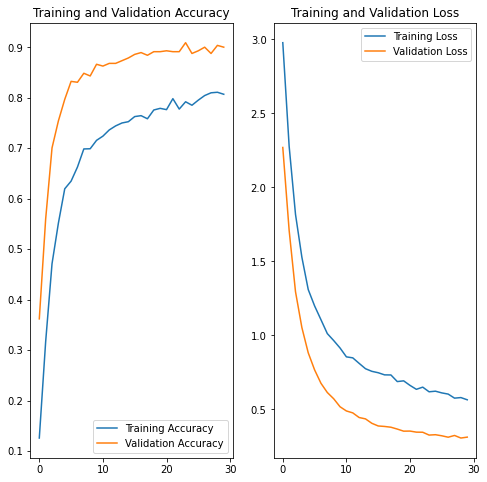

In [ ]:
plot_history(history,30)

L'apprentissage de la couche de prédiction permet d'obtenir un précision d'environ 90%.  
On remarque que la précision sur la jeu d'entrainement est plus faible, ce qui est dû aux méthodes permettant d'aténuer le sur-apprentissage.

### fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

On apprend les 54 couches les plus hautes du modèle.
Cela représente 1.9M de paramètres.

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 30/60
87/87 [==============================] - 11s 73ms/step - loss: 0.5757 - accuracy: 0.8058 - val_loss: 0.3036 - val_accuracy: 0.8913
Epoch 31/60
87/87 [==============================] - 6s 63ms/step - loss: 0.5324 - accuracy: 0.8178 - val_loss: 0.2895 - val_accuracy: 0.8895
Epoch 32/60
87/87 [==============================] - 6s 64ms/step - loss: 0.4990 - accuracy: 0.8261 - val_loss: 0.2891 - val_accuracy: 0.8841
Epoch 33/60
87/87 [==============================] - 6s 65ms/step - loss: 0.4827 - accuracy: 0.8348 - val_loss: 0.2617 - val_accuracy: 0.9055
Epoch 34/60
87/87 [==============================] - 6s 64ms/step - loss: 0.4690 - accuracy: 0.8341 - val_loss: 0.2781 - val_accuracy: 0.9020
Epoch 35/60
87/87 [==============================] - 6s 64ms/step - loss: 0.4422 - accuracy: 0.8467 - val_loss: 0.2689 - val_accuracy: 0.9020
Epoch 36/60
87/87 [==============================] - 6s 64ms/step - loss: 0.4496 - accuracy: 0.8402 - val_loss: 0.2571 - val_accuracy: 0.9002
Epoch

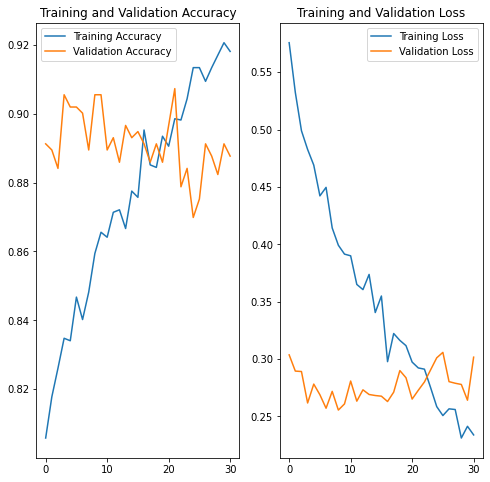

In [ ]:
plot_history(history_fine, 31)

Le fine tuning ne permet pas d'améliorer la performance du jeu de validation mais provoque un sur-apprentissage.  
Cela est causé par le trop grand nombre de paramètres entrainables.

### diminution de l'augmentation de données

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 9s 65ms/step - loss: 0.4047 - accuracy: 0.8565 - val_loss: 0.3029 - val_accuracy: 0.8948
Epoch 2/30
87/87 [==============================] - 5s 56ms/step - loss: 0.3978 - accuracy: 0.8656 - val_loss: 0.2920 - val_accuracy: 0.8913
Epoch 3/30
87/87 [==============================] - 5s 57ms/step - loss: 0.3852 - accuracy: 0.8743 - val_loss: 0.2942 - val_accuracy: 0.8930
Epoch 4/30
87/87 [==============================] - 5s 57ms/step - loss: 0.3766 - accuracy: 0.8754 - val_loss: 0.3004 - val_accuracy: 0.8930
Epoch 5/30
87/87 [==============================] - 5s 58ms/step - loss: 0.3654 - accuracy: 0.8819 - val_loss: 0.2829 - val_accuracy: 0.8913
Epoch 6/30
87/87 [==============================] - 5s 57ms/step - loss: 0.3608 - accuracy: 0.8775 - val_loss: 0.2709 - val_accuracy: 0.9055
Epoch 7/30
87/87 [==============================] - 5s 57ms/step - loss: 0.3561 - accuracy: 0.8888 - val_loss: 0.2710 - val_accuracy: 0.9055
Epoch 8/30
87

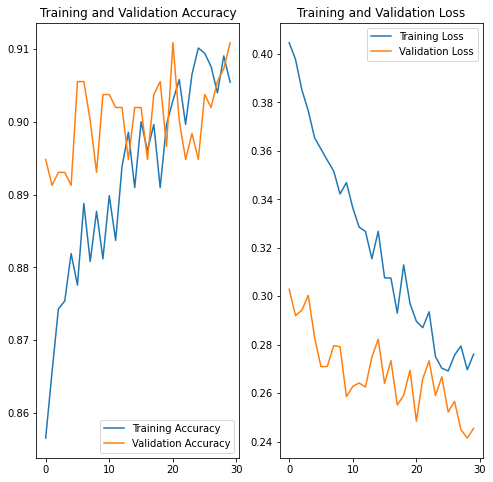

In [ ]:
plot_history(history,30)

La diminition de l'augmentation de données permet d'améliorer très légérement la précision mais augmente également le sur-apprentissage.

### diminution du Dropout

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 9s 66ms/step - loss: 0.2517 - accuracy: 0.9210 - val_loss: 0.2425 - val_accuracy: 0.9073
Epoch 2/30
87/87 [==============================] - 5s 58ms/step - loss: 0.2519 - accuracy: 0.9174 - val_loss: 0.2568 - val_accuracy: 0.8984
Epoch 3/30
87/87 [==============================] - 5s 57ms/step - loss: 0.2419 - accuracy: 0.9261 - val_loss: 0.2401 - val_accuracy: 0.9073
Epoch 4/30
87/87 [==============================] - 7s 74ms/step - loss: 0.2372 - accuracy: 0.9214 - val_loss: 0.2499 - val_accuracy: 0.9020
Epoch 5/30
87/87 [==============================] - 5s 57ms/step - loss: 0.2410 - accuracy: 0.9199 - val_loss: 0.2563 - val_accuracy: 0.8984
Epoch 6/30
87/87 [==============================] - 5s 57ms/step - loss: 0.2417 - accuracy: 0.9196 - val_loss: 0.2657 - val_accuracy: 0.8930
Epoch 7/30
87/87 [==============================] - 5s 57ms/step - loss: 0.2191 - accuracy: 0.9275 - val_loss: 0.2628 - val_accuracy: 0.8984
Epoch 8/30
87

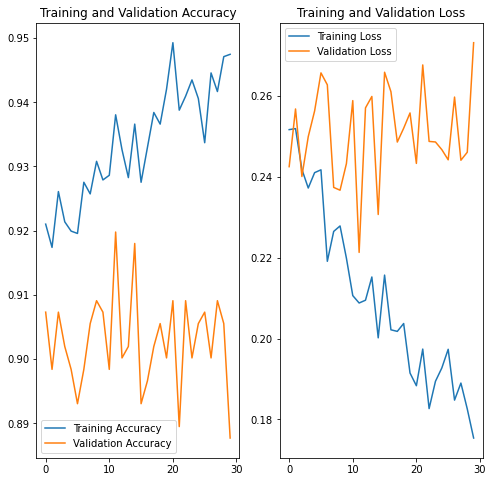

In [ ]:
plot_history(history,30)

La diminution du dropout n'améliore pas la précision, il favorise uniquement le sur-apprentissage.

### ajout de couche fully-connected

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

L'ajout de deux couches fully-connected augmente très fortement le nombre de paramètres entrainables et non pré-entrainés.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 9s 65ms/step - loss: 1.0157 - accuracy: 0.7120 - val_loss: 0.3512 - val_accuracy: 0.8806
Epoch 2/30
87/87 [==============================] - 5s 57ms/step - loss: 0.4848 - accuracy: 0.8319 - val_loss: 0.3154 - val_accuracy: 0.8877
Epoch 3/30
87/87 [==============================] - 5s 58ms/step - loss: 0.4041 - accuracy: 0.8554 - val_loss: 0.3677 - val_accuracy: 0.8788
Epoch 4/30
87/87 [==============================] - 7s 76ms/step - loss: 0.3352 - accuracy: 0.8848 - val_loss: 0.2761 - val_accuracy: 0.8895
Epoch 5/30
87/87 [==============================] - 5s 58ms/step - loss: 0.3075 - accuracy: 0.8880 - val_loss: 0.3294 - val_accuracy: 0.8895
Epoch 6/30
87/87 [==============================] - 5s 59ms/step - loss: 0.2507 - accuracy: 0.9152 - val_loss: 0.3276 - val_accuracy: 0.8806
Epoch 7/30
87/87 [==============================] - 5s 58ms/step - loss: 0.2409 - accuracy: 0.9098 - val_loss: 0.2670 - val_accuracy: 0.8984
Epoch 8/30
87

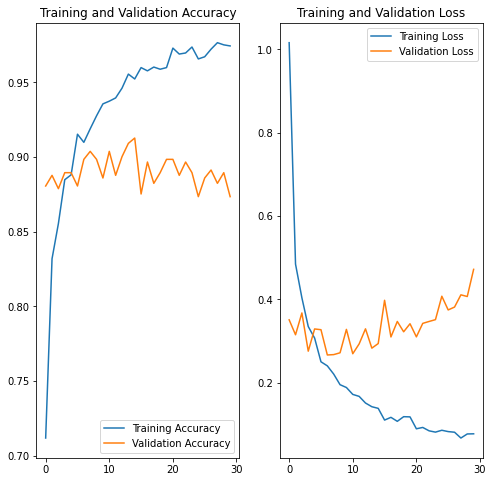

In [ ]:
plot_history(history,30)

Les couches fully-connected ne permettent pas d'améliorer la performance sur le jeu de validation.

## Transfer learning Xception

### Visualisation du modèle

In [ ]:
xception = keras.applications.Xception(weights='imagenet')  # Load weights pre-trained on ImageNet.
xception.summary()

91897856/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

### Création du dataset

In [ ]:
train_ds, val_ds = load_data(DIR+"/Images", height=150, width=150, batch_size=32)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Base model

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

83697664/83683744 [==============================] - 0s 0us/step


### Création du modèle
Le modèle est créé suivant la même démarche que précédemment.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
preprocess_input = tf.keras.applications.xception.preprocess_input
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

L'apprentissage de la couche de prédictions contient 40k paramètres.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(val_ds)

18/18 [==============================] - 4s 98ms/step - loss: 3.4473 - accuracy: 0.0731


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 11s 86ms/step - loss: 2.7074 - accuracy: 0.2040 - val_loss: 1.8699 - val_accuracy: 0.4724
Epoch 2/30
87/87 [==============================] - 8s 88ms/step - loss: 1.7043 - accuracy: 0.5239 - val_loss: 1.1798 - val_accuracy: 0.7237
Epoch 3/30
87/87 [==============================] - 7s 82ms/step - loss: 1.2921 - accuracy: 0.6428 - val_loss: 0.9033 - val_accuracy: 0.7701
Epoch 4/30
87/87 [==============================] - 8s 83ms/step - loss: 1.0594 - accuracy: 0.6877 - val_loss: 0.7697 - val_accuracy: 0.7879
Epoch 5/30
87/87 [==============================] - 8s 83ms/step - loss: 0.9564 - accuracy: 0.7087 - val_loss: 0.6810 - val_accuracy: 0.8057
Epoch 6/30
87/87 [==============================] - 8s 86ms/step - loss: 0.8867 - accuracy: 0.7156 - val_loss: 0.6404 - val_accuracy: 0.8093
Epoch 7/30
87/87 [==============================] - 8s 87ms/step - loss: 0.8503 - accuracy: 0.7319 - val_loss: 0.6175 - val_accuracy: 0.8021
Epoch 8/30
8

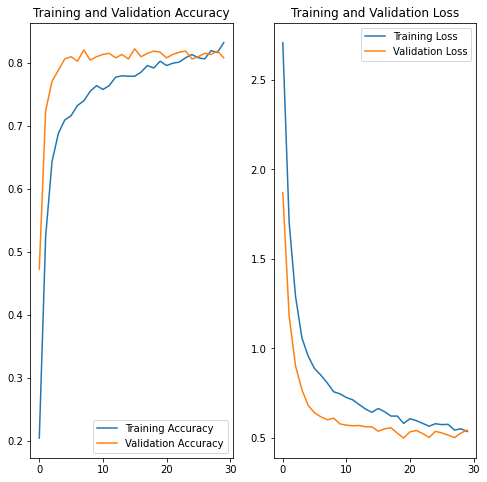

In [ ]:
plot_history(history, 30)

La précision du modèle est d'environ 80%.  Au delà de 30 epochs on semble entrer dans une phase de sur-apprentissage.

### fine tuning

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [ ]:
fine_tune_at = 100
base_model.trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

L'apprentissage des 32 dernières couches contient 9.5M de paramètres.

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 30/60
87/87 [==============================] - 16s 133ms/step - loss: 0.5027 - accuracy: 0.8272 - val_loss: 0.5187 - val_accuracy: 0.8182
Epoch 31/60
87/87 [==============================] - 11s 122ms/step - loss: 0.4962 - accuracy: 0.8362 - val_loss: 0.5071 - val_accuracy: 0.8307
Epoch 32/60
87/87 [==============================] - 11s 122ms/step - loss: 0.4675 - accuracy: 0.8384 - val_loss: 0.5172 - val_accuracy: 0.8307
Epoch 33/60
87/87 [==============================] - 11s 124ms/step - loss: 0.4647 - accuracy: 0.8275 - val_loss: 0.5295 - val_accuracy: 0.8289
Epoch 34/60
87/87 [==============================] - 11s 122ms/step - loss: 0.4356 - accuracy: 0.8518 - val_loss: 0.5262 - val_accuracy: 0.8200
Epoch 35/60
87/87 [==============================] - 11s 124ms/step - loss: 0.4009 - accuracy: 0.8620 - val_loss: 0.5298 - val_accuracy: 0.8307
Epoch 36/60
87/87 [==============================] - 11s 124ms/step - loss: 0.4091 - accuracy: 0.8536 - val_loss: 0.4946 - val_accuracy:

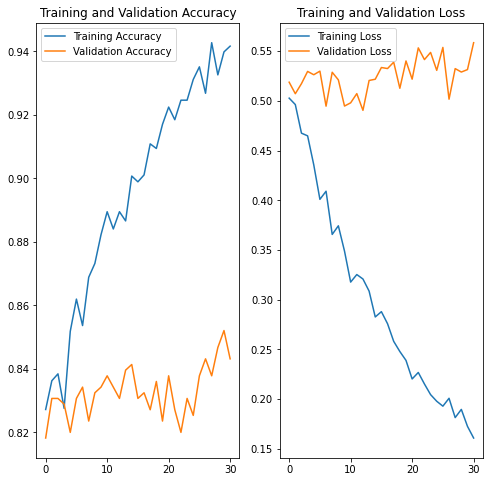

In [ ]:
plot_history(history_fine, 31)

Le fine-tunning permet d'améliorer légérement le précision sur le jeu de validation mais on observe surtout un sur-apprentissage causé par le trop grand nombre de paramètres.

## Transfer learning ResNet 50

### Visualisation du modèle

In [8]:
resnet = keras.applications.ResNet50(weights='imagenet') 
resnet.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

### Création du dataset

In [9]:
train_ds, val_ds = load_data(DIR+"/Images", height=230, width=230, batch_size=32)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)

Found 3449 files belonging to 20 classes.
Using 2760 files for training.
Found 3449 files belonging to 20 classes.
Using 689 files for validation.
5


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### base model

In [11]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(230, 230, 3),
    include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


### creation du modèle

In [12]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), 
                                      layers.RandomRotation(0.2), 
                                      layers.RandomZoom(0.2)])

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [14]:
inputs = tf.keras.Input(shape=(230, 230, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 230, 230, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 230, 230, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 230, 230, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

L'apprentissage de la couche de prédictions contient environ 41k paramètres.

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(val_ds)

18/18 [==============================] - 16s 138ms/step - loss: 3.5215 - accuracy: 0.0731


### Apprentissage de la dernière couche

In [18]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 18s 155ms/step - loss: 3.1099 - accuracy: 0.0996 - val_loss: 2.5181 - val_accuracy: 0.2353
Epoch 2/30
87/87 [==============================] - 13s 150ms/step - loss: 2.4602 - accuracy: 0.2533 - val_loss: 1.8874 - val_accuracy: 0.4955
Epoch 3/30
87/87 [==============================] - 13s 150ms/step - loss: 2.0683 - accuracy: 0.3895 - val_loss: 1.4630 - val_accuracy: 0.6257
Epoch 4/30
87/87 [==============================] - 13s 151ms/step - loss: 1.7411 - accuracy: 0.5047 - val_loss: 1.1989 - val_accuracy: 0.6898
Epoch 5/30
87/87 [==============================] - 14s 157ms/step - loss: 1.5474 - accuracy: 0.5475 - val_loss: 1.0261 - val_accuracy: 0.7487
Epoch 6/30
87/87 [==============================] - 14s 152ms/step - loss: 1.3465 - accuracy: 0.6232 - val_loss: 0.8791 - val_accuracy: 0.7986
Epoch 7/30
87/87 [==============================] - 14s 152ms/step - loss: 1.2613 - accuracy: 0.6428 - val_loss: 0.7750 - val_accuracy: 0.8146

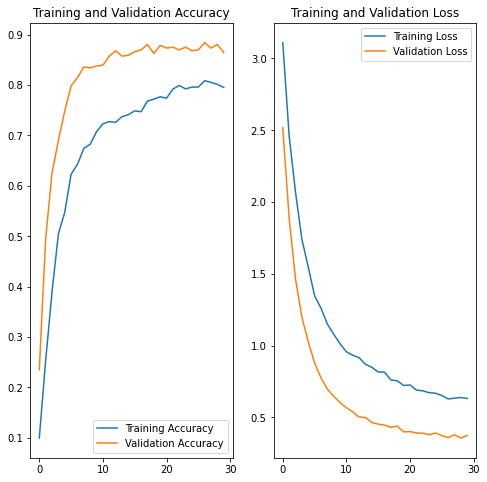

In [19]:
plot_history(history, 30)

La précision obtenue sur le jeu de validation est d'environ 88%. Aucun sur-apprentissage n'est détecté.

### fine-tunning

In [23]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [24]:
fine_tune_at = 120
base_model.trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 30/60
87/87 [==============================] - 28s 236ms/step - loss: 0.5518 - accuracy: 0.8134 - val_loss: 0.3123 - val_accuracy: 0.8770
Epoch 31/60
87/87 [==============================] - 20s 223ms/step - loss: 0.4870 - accuracy: 0.8279 - val_loss: 0.3070 - val_accuracy: 0.8895
Epoch 32/60
87/87 [==============================] - 20s 226ms/step - loss: 0.4382 - accuracy: 0.8486 - val_loss: 0.3145 - val_accuracy: 0.8734
Epoch 33/60
87/87 [==============================] - 20s 225ms/step - loss: 0.4069 - accuracy: 0.8554 - val_loss: 0.2887 - val_accuracy: 0.8895
Epoch 34/60
87/87 [==============================] - 20s 224ms/step - loss: 0.3630 - accuracy: 0.8703 - val_loss: 0.3003 - val_accuracy: 0.8913
Epoch 35/60
87/87 [==============================] - 20s 225ms/step - loss: 0.3626 - accuracy: 0.8783 - val_loss: 0.2917 - val_accuracy: 0.8806
Epoch 36/60
87/87 [==============================] - 21s 232ms/step - loss: 0.3063 - accuracy: 0.8884 - val_loss: 0.2658 - val_accuracy:

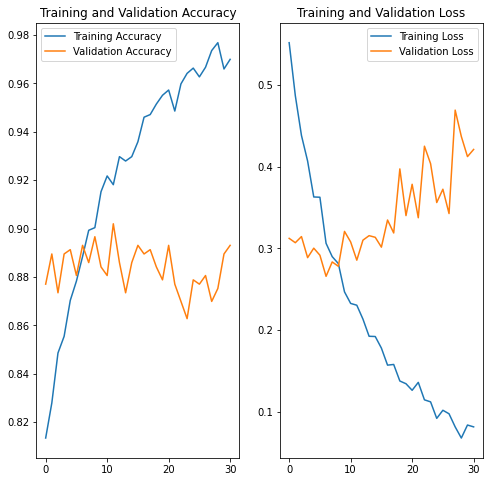

In [27]:
plot_history(history_fine, 31)

Le fine-tunning ne permet pas d'améliorer la précision sur le jeu de validation. On est uniquement en sur-apprentissage.

### Diminuer l'augmentation de données


In [28]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(230, 230, 3),
    include_top=False)

In [29]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), 
                                      layers.RandomRotation(0.1), 
                                      layers.RandomZoom(0.05)])

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [31]:
inputs = tf.keras.Input(shape=(230, 230, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 22s 191ms/step - loss: 3.0277 - accuracy: 0.1029 - val_loss: 2.3749 - val_accuracy: 0.2531
Epoch 2/30
87/87 [==============================] - 15s 157ms/step - loss: 2.3492 - accuracy: 0.2844 - val_loss: 1.7457 - val_accuracy: 0.5633
Epoch 3/30
87/87 [==============================] - 14s 152ms/step - loss: 1.9192 - accuracy: 0.4591 - val_loss: 1.3504 - val_accuracy: 0.7077
Epoch 4/30
87/87 [==============================] - 14s 154ms/step - loss: 1.6107 - accuracy: 0.5601 - val_loss: 1.0902 - val_accuracy: 0.7558
Epoch 5/30
87/87 [==============================] - 14s 152ms/step - loss: 1.4214 - accuracy: 0.5957 - val_loss: 0.8939 - val_accuracy: 0.7986
Epoch 6/30
87/87 [==============================] - 14s 155ms/step - loss: 1.2434 - accuracy: 0.6623 - val_loss: 0.7791 - val_accuracy: 0.8235
Epoch 7/30
87/87 [==============================] - 14s 152ms/step - loss: 1.1433 - accuracy: 0.6815 - val_loss: 0.6947 - val_accuracy: 0.8467

La diminution de l'augmentation des données permet une très légère amélioration de la précision.

### diminution du dropout

In [36]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(230, 230, 3),
    include_top=False)

In [37]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), 
                                      layers.RandomRotation(0.1), 
                                      layers.RandomZoom(0.05)])

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation="softmax")
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [39]:
inputs = tf.keras.Input(shape=(230, 230, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers :
    layer.trainable = False

In [40]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
87/87 [==============================] - 18s 168ms/step - loss: 2.8862 - accuracy: 0.1359 - val_loss: 2.2997 - val_accuracy: 0.2923
Epoch 2/30
87/87 [==============================] - 14s 156ms/step - loss: 2.2076 - accuracy: 0.3652 - val_loss: 1.6847 - val_accuracy: 0.5544
Epoch 3/30
87/87 [==============================] - 14s 156ms/step - loss: 1.7756 - accuracy: 0.5152 - val_loss: 1.2968 - val_accuracy: 0.6774
Epoch 4/30
87/87 [==============================] - 14s 156ms/step - loss: 1.5093 - accuracy: 0.5833 - val_loss: 1.0585 - val_accuracy: 0.7433
Epoch 5/30
87/87 [==============================] - 14s 156ms/step - loss: 1.3107 - accuracy: 0.6478 - val_loss: 0.8922 - val_accuracy: 0.7914
Epoch 6/30
87/87 [==============================] - 14s 157ms/step - loss: 1.1781 - accuracy: 0.6761 - val_loss: 0.7907 - val_accuracy: 0.7968
Epoch 7/30
87/87 [==============================] - 14s 155ms/step - loss: 1.0704 - accuracy: 0.6989 - val_loss: 0.7194 - val_accuracy: 0.7986

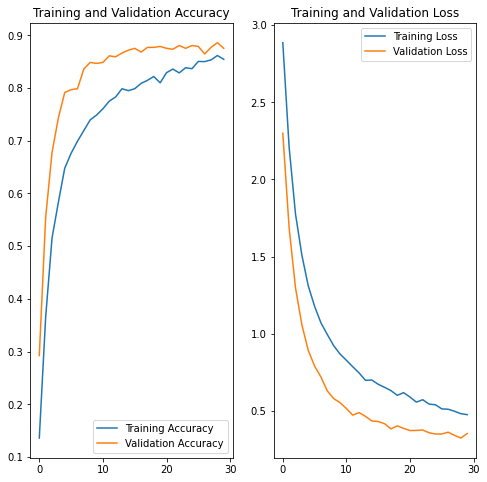

In [43]:
plot_history(history, 30)

In [44]:
fine_tune_at = 100
base_model.trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [45]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [46]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 30/60
87/87 [==============================] - 28s 253ms/step - loss: 0.4215 - accuracy: 0.8609 - val_loss: 0.2870 - val_accuracy: 0.9109
Epoch 31/60
87/87 [==============================] - 21s 241ms/step - loss: 0.3623 - accuracy: 0.8736 - val_loss: 0.3005 - val_accuracy: 0.8859
Epoch 32/60
87/87 [==============================] - 22s 243ms/step - loss: 0.3062 - accuracy: 0.8891 - val_loss: 0.3208 - val_accuracy: 0.8841
Epoch 33/60
87/87 [==============================] - 22s 244ms/step - loss: 0.2665 - accuracy: 0.9072 - val_loss: 0.2751 - val_accuracy: 0.8948
Epoch 34/60
87/87 [==============================] - 21s 243ms/step - loss: 0.2335 - accuracy: 0.9181 - val_loss: 0.3113 - val_accuracy: 0.8913
Epoch 35/60
87/87 [==============================] - 22s 244ms/step - loss: 0.2117 - accuracy: 0.9272 - val_loss: 0.3178 - val_accuracy: 0.8788
Epoch 36/60
87/87 [==============================] - 22s 247ms/step - loss: 0.1908 - accuracy: 0.9391 - val_loss: 0.3534 - val_accuracy:

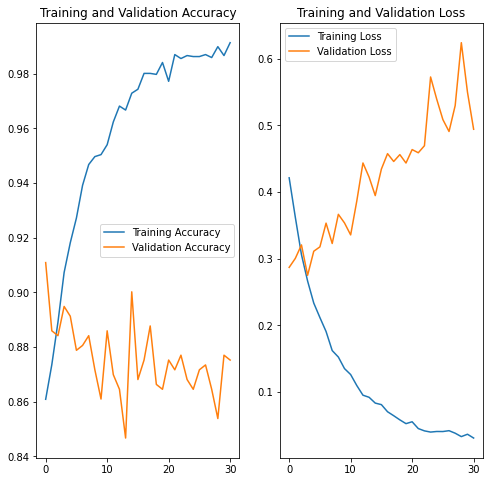

In [47]:
plot_history(history_fine, 31)

Le fine tunning sur un modèle avec un dropout et une augmentation des données plus faible provoque une augmention significative du sur-apprentissage.

## Conclusions :
- Les modèles non pré-entrainés ne permettent pas d'atteindre une performance satisfaisante.
- Complexifier les modèles non pré-entrainés n'améliore pas forcément la performance mais engendre surtout du sur-apprentissage causé par le nombre croissant de paramètre
- l'ensemble des modèles pré-entrainés ont des performances satisfaisantes (>80%)
- entrainer plus que la couche de prédictions induit du sur-entrainement causé par la trop faible quantité d'images
- le modèle MobileNet_V2 semble donner la meilleure performance avec un cout de calcul limité.

## A suivre :
- le modèle MobileNet_V2 sera appris sur la totalité du DataSet grâce à un code specifique pouvant tourner sur AWS ou sur une autre machine Linux.
- Des checkpoints seront sauvegardés pour obtenir le meilleur modèle sur le jeu de validation
- l'apprentissage se fera en 2 étapes : 
-- Apprentissage de la couche de prédictions
-- fine tuning